In [29]:
import numpy as np
import pandas as pd
import uproot3 as uproot
import matplotlib.pyplot as plt 

import os 

def _getCurrent(df, adc2pc=(0.122*2.0)/50.0):
    
    nevents = len(np.unique( df.event ))
    nticks = df.nticks.values[0]
    current = ( np.sum( df.chargesum )*adc2pc / ( nevents * nticks * 2e-9 ) ) * 1e-6 #in uA
   
    return current 



def getDataFrame( tfile, selbranches = [ "chargesum", "ch", "nticks", "event" ], flatenndf=True ):
    
    ttree = uproot.open(tfile)
    timestamp = ttree["anodecharge/wftree"].array("run")[0]
    data = ttree["anodecharge/wftree"].arrays(branches=selbranches, outputtype=pd.DataFrame, flatten=flatenndf)

    print(tfile, timestamp)
    
    if len(data) == 0:
        print( "Skip file {}".format(tfile) )
        return 
    
    nticks = data.nticks.values[0]

    df = data.groupby("ch").apply(lambda x : _getCurrent(x) ).to_frame()    
    df.rename(columns={0:"current"}, inplace=True)
    
    df["timestamp"] = timestamp
    df["nticks"] = nticks 
    #df["baseline"] = data.groupby("ch").baseline.mean()
    
    df=df.reset_index()
    df=df.set_index("timestamp")
    
    ttree.close()
    
    return df

# Rates only for a specific run
sourcedir="/icarus/data/calibration/PMT/equalization/"
data = pd.concat([ getDataFrame(sourcedir+file) for file in  os.listdir(sourcedir) if "anodecharge_run" in file ])

# Correct for the adders installation 
data.loc[data.index>=6372, 'current'] = data.loc[data.index>=6372, 'current']*1.1 #Dumb compensation for the adders

data = data.sort_index()

/icarus/data/calibration/PMT/equalization/anodecharge_run4466.root 4466
/icarus/data/calibration/PMT/equalization/anodecharge_run7033.root 7033
/icarus/data/calibration/PMT/equalization/anodecharge_run5679.root 5679
/icarus/data/calibration/PMT/equalization/anodecharge_run6069.root 6069
/icarus/data/calibration/PMT/equalization/anodecharge_run5216.root 5216
/icarus/data/calibration/PMT/equalization/anodecharge_run6736.root 6736


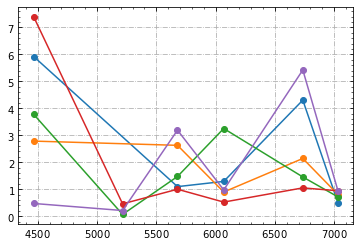

In [30]:
plt.plot( data[(data.ch==4)].current, 'o-' ) 
plt.plot( data[(data.ch==10)].current, 'o-' ) 
plt.plot( data[(data.ch==180)].current, 'o-' ) 
plt.plot( data[(data.ch==234)].current, 'o-' ) 
plt.plot( data[(data.ch==341)].current, 'o-' ) 
#plt.plot( data[(data.channel_id==10)].current, 'o' ) 
#plt.plot( data[(data.channel_id==30)].current, 'o' ) 

NameError: name 'sdf' is not defined

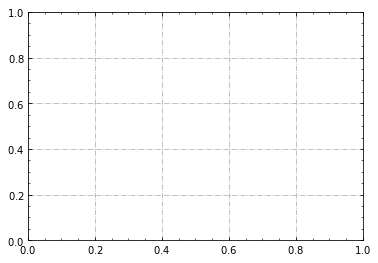

In [27]:
## THIS HISTOGRAM SHOWS THE CURRENTS CROSSED ON EACH PMT

def _getCurrent(charge, nevents, nticks, adc2pc=(0.122*2.0)/50.0):
    current = ( charge*adc2pc / ( nevents * nticks * 2e-9 ) ) * 1e-6 #in uA
    
    return current 

def groupdf( df, adc2pc=(0.122*2.0)/50.0 ):
    gdf = df.groupby( "channel_id" ).agg( {'chargesum':'sum', 'nticks':'mean', 'event':'count'} )
    gdf['current'] = gdf.apply( lambda x : _getCurrent( x.chargesum, x.event, x.nticks, adc2pc ) ,axis=1 )
    return gdf


def makelabel(df):
    
    mean = np.mean(df.current)
    stdev = np.std(df.current)
    
    label = "Mean %.2f uA\nStd.Dev. %.2f uA" % ( mean, stdev )
    
    return label




fig,ax = plt.subplots(1,1, figsize=(6, 4.2))

kargs={'bins':20, 'histtype':'step', 'lw':2.0}


gdf = groupdf(sdf, adc2pc*1.1) #Rescale for adders 
ll = "\n " + makelabel(gdf)
ax.hist( gdf.current, label="September 2021"+ll, **kargs)

gdf2 = groupdf(sdf2)
ll = "\n " + makelabel(gdf2)
ax.hist( gdf2.current, label="April 2021"+ll, **kargs)

gdf3 = groupdf(sdf1)
ll = "\n " + makelabel(gdf3)
ax.hist( gdf3.current, label="February 2021"+ll, **kargs)

ax.legend(loc='upper right')
ax.set_ylabel("# of PMTs", fontsize=14)
ax.set_xlabel("Current [uA]", fontsize=14)



In [28]:
from ROOT import TFile, TH1D

def _getChargeFromHist( file, nevents, readout, adders ):

    tfile=TFile.Open(file)
    hcharge = tfile.Get("bkgcalibration/hintegral1")

    electrons = np.sum([ hcharge.GetBinCenter(i)*hcharge.GetBinContent(i) for i in range(0, hcharge.GetNbinsX()+2)] )

    print(file, _getCurrent( electrons*1.60218 , nevents, readout, adders ) )
    
_getChargeFromHist("../histograms/pulseDistributionHist_run6842.root",7232, 15000, 1.1) # SEP 20
_getChargeFromHist("../histograms/pulseDistributionHist_run5573.root", 7500, 12500, 1.0) # APR 16
_getChargeFromHist("../histograms/pulseDistributionHist_run5077.root", 7500, 5000, 1.0) # FEB 26 ( readout 10 us)

../histograms/pulseDistributionHist_run6842.root 0.3489565910923673
../histograms/pulseDistributionHist_run5573.root 0.37615136088959994
../histograms/pulseDistributionHist_run5077.root 0.39377952792
